![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 9 - Tips and Tricks </center>
### <center> Label Smoothing </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/09_TipsAndTricks/MainLabelSmoothing.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/09_TipsAndTricks/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [4]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR

torch.backends.cudnn.benchmark = True

For Colab users:

In [5]:
from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR-10 dataset:

In [6]:
DATA_PATH = '../../data/'
oTrainSet = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [7]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

#### Plot some examples:

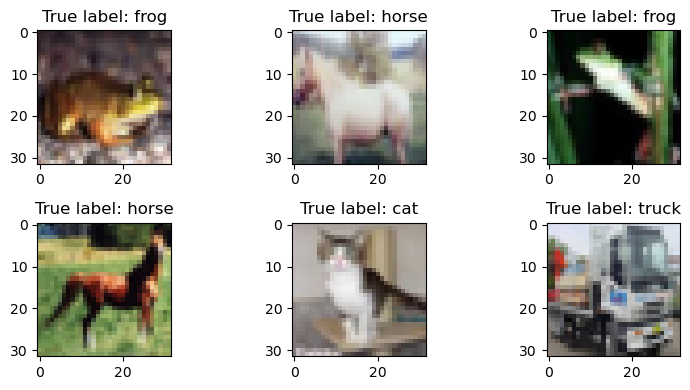

In [8]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow   (mX.permute(1,2,0))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show        ()

#### Compute mean and variance:

In [9]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with augmentations:

In [10]:
oTrainTransform = transforms.Compose([
    transforms.AutoAugment         (policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor            (),
    transforms.Normalize           (vMean, vStd),
])

oTestTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(vMean, vStd),
])

oTrainSet.transform = oTrainTransform
oTestSet .transform = oTestTransform

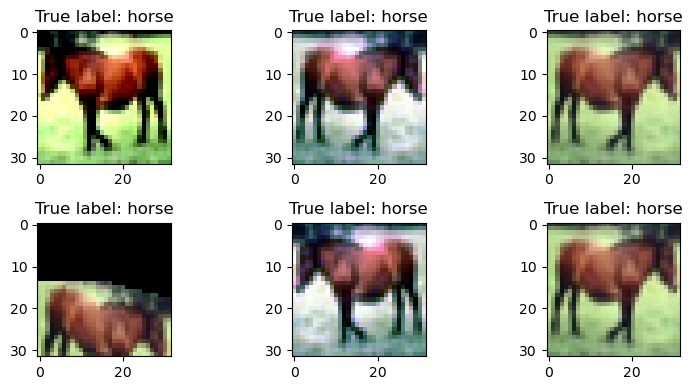

In [11]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = 7
    mX, y = oTrainSet[idx]
#     mX, y = oTestSet [idx]
    mX    = mX.permute(1,2,0)
    ax.imshow   (np.clip(mX * vStd[None,None,:] + vMean[None,None,:], 0, 1))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show        ()

#### Create data loaders:

In [12]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

#### Define the model (ResNet):

In [13]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        self.oBlock  = nn.Sequential(
            nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding=1, bias=False),
            nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding=1, bias=False)
        )
        
    def forward(self, mX):
        mZ = self.oBlock(mX) + mX
        return mZ
        
torchinfo.summary(ResBlock(64), (4, 64, 56, 56))

Layer (type:depth-idx)                   Output Shape              Param #
ResBlock                                 --                        --
├─Sequential: 1-1                        [4, 64, 56, 56]           --
│    └─BatchNorm2d: 2-1                  [4, 64, 56, 56]           128
│    └─ReLU: 2-2                         [4, 64, 56, 56]           --
│    └─Conv2d: 2-3                       [4, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-4                  [4, 64, 56, 56]           128
│    └─ReLU: 2-5                         [4, 64, 56, 56]           --
│    └─Conv2d: 2-6                       [4, 64, 56, 56]           36,864
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
Total mult-adds (M): 924.85
Input size (MB): 3.21
Forward/backward pass size (MB): 25.69
Params size (MB): 0.30
Estimated Total Size (MB): 29.20

In [14]:
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def InitWeights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def GetModel():
    d      = 128
    oModel = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),
        nn.Conv2d(d, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),  nn.MaxPool2d(2),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),
        nn.Linear           (d, 10)
    )
    
    oModel.apply(InitWeights)
    
    return oModel
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), (4, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [4, 3, 32, 32]            --
├─Conv2d: 1-2                            [4, 128, 32, 32]          3,456
├─BatchNorm2d: 1-3                       [4, 128, 32, 32]          256
├─ReLU: 1-4                              [4, 128, 32, 32]          --
├─Conv2d: 1-5                            [4, 128, 32, 32]          147,456
├─BatchNorm2d: 1-6                       [4, 128, 32, 32]          256
├─ReLU: 1-7                              [4, 128, 32, 32]          --
├─MaxPool2d: 1-8                         [4, 128, 16, 16]          --
├─ResBlock: 1-9                          [4, 128, 16, 16]          --
│    └─Sequential: 2-1                   [4, 128, 16, 16]          --
│    │    └─BatchNorm2d: 3-1             [4, 128, 16, 16]          256
│    │    └─ReLU: 3-2                    [4, 128, 16, 16]          --
│   

### Label Smoothing
* Cross-entropy loss:
$$
\ell_{\mathrm{CE}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \boldsymbol{y}_{i},\log\left(\hat{\boldsymbol{y}}_{i}\right)\right\rangle =-\left\langle \left[\begin{matrix}0\\
1\\
0\\
0
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle 
$$
* Label-smoothing loss:
$$
\ell_{\mathrm{LS}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \left[\begin{matrix}\frac{\epsilon}{3}\\
1-\epsilon\\
\frac{\epsilon}{3}\\
\frac{\epsilon}{3}
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle 
$$
#### Smooth labels code (example):

In [15]:
N    = 10                         #-- number of samples
C    = 4                          #-- number of classes (labels)
vIdx = torch.randint(0, C, (N,))  #-- correct labels
vIdx

tensor([1, 3, 1, 3, 0, 1, 2, 3, 0, 1])

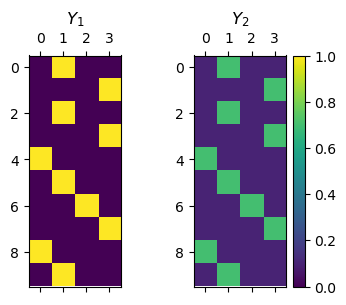

In [16]:
#-- mY1 (one hot):
mY1 = torch.zeros(N, C).scatter_(1, vIdx.unsqueeze(1), 1)

#-- mY2 (smooth):
ϵ   = 0.3
mY2 = torch.empty(N, C).fill_(ϵ / (C-1)).scatter_(1, vIdx.unsqueeze(1), 1-ϵ)

_, ax = plt.subplots(1, 2, figsize=(4, 3))
h = ax[0].matshow(mY1, vmin=0, vmax=1)
h = ax[1].matshow(mY2, vmin=0, vmax=1)
ax[0].set_title  ('$Y_1$')
ax[1].set_title  ('$Y_2$')
plt.colorbar     (h)
plt.show         ()

In [17]:
mY1, mY2

(tensor([[0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.]]),
 tensor([[0.1000, 0.7000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.7000],
         [0.1000, 0.7000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.7000],
         [0.7000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.7000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.7000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.7000],
         [0.7000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.7000, 0.1000, 0.1000]]))

#### Label smoothing loss:
$$\ell_{\mathrm{LS}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \left[\begin{matrix}\frac{\epsilon}{3}\\
1-\epsilon\\
\frac{\epsilon}{3}\\
\frac{\epsilon}{3}
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle $$
https://github.com/pytorch/pytorch/issues/7455

In [18]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, nClass, ε=0.01):
        super().__init__()
        self.nClass = nClass
        self.ε      = ε

    def forward(self, mScore, vY):
        ε      = self.ε
        nClass = self.nClass
        mScore = mScore.log_softmax(dim=-1)

        with torch.no_grad():
            mSmoothY = torch.empty_like(mScore).fill_(ε / (nClass - 1))
            mSmoothY.scatter_(1, vY.unsqueeze(1), 1-ε)

        return torch.mean( torch.sum(-mSmoothY * mScore, dim=-1) )

In [19]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = LabelSmoothingLoss(10, ε=0.1)

In [20]:
nEpochs       = 250
nIter         = nEpochs * len(oTrainDL)

oModel        = GetModel               ().to(DEVICE)
oOptim        = optim.AdamW            (oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=1e-2)
oScheduler    = OneCycleLR             (oOptim, max_lr=5e-3, total_steps=nIter)
lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss: 1.82773 | Val loss: 1.56583 | Train Accuracy: 0.3974 | Val Accuracy: 0.5071 | epoch time: 29.211 | <-- Checkpoint!
Epoch 001: | Train loss: 1.54557 | Val loss: 1.29853 | Train Accuracy: 0.5422 | Val Accuracy: 0.6617 | epoch time: 22.173 | <-- Checkpoint!
Epoch 002: | Train loss: 1.42239 | Val loss: 1.30340 | Train Accuracy: 0.6058 | Val Accuracy: 0.6752 | epoch time: 22.127 | <-- Checkpoint!
Epoch 003: | Train loss: 1.32218 | Val loss: 1.24025 | Train Accuracy: 0.6594 | Val Accuracy: 0.7135 | epoch time: 22.141 | <-- Checkpoint!
Epoch 004: | Train loss: 1.25746 | Val loss: 1.12335 | Train Accuracy: 0.6927 | Val Accuracy: 0.7666 | epoch time: 22.222 | <-- Checkpoint!
Epoch 005: | Train loss: 1.20197 | Val loss: 1.12722 | Train Accuracy: 0.7193 | Val Accuracy: 0.7690 | epoch time: 22.225 | <-- Checkpoint!
Epoch 006: | Train loss: 1.17105 | Val loss: 1.09827 | Train Accuracy: 0.7358 | Val Accuracy: 0.7628 | epoch time: 22.188 |
Epoch 007: | Train loss: 1.12729 | V

Epoch 064: | Train loss: 0.78695 | Val loss: 0.78304 | Train Accuracy: 0.9027 | Val Accuracy: 0.9074 | epoch time: 21.790 | <-- Checkpoint!
Epoch 065: | Train loss: 0.79022 | Val loss: 0.79082 | Train Accuracy: 0.9019 | Val Accuracy: 0.9003 | epoch time: 21.786 |
Epoch 066: | Train loss: 0.78847 | Val loss: 0.77895 | Train Accuracy: 0.9036 | Val Accuracy: 0.9060 | epoch time: 21.796 |
Epoch 067: | Train loss: 0.78268 | Val loss: 0.79554 | Train Accuracy: 0.9051 | Val Accuracy: 0.8993 | epoch time: 21.824 |
Epoch 068: | Train loss: 0.78241 | Val loss: 0.77675 | Train Accuracy: 0.9052 | Val Accuracy: 0.9065 | epoch time: 21.789 |
Epoch 069: | Train loss: 0.78210 | Val loss: 0.78799 | Train Accuracy: 0.9051 | Val Accuracy: 0.9033 | epoch time: 21.797 |
Epoch 070: | Train loss: 0.77432 | Val loss: 0.82698 | Train Accuracy: 0.9094 | Val Accuracy: 0.8883 | epoch time: 21.792 |
Epoch 071: | Train loss: 0.77410 | Val loss: 0.77995 | Train Accuracy: 0.9076 | Val Accuracy: 0.9092 | epoch time: 2

Epoch 129: | Train loss: 0.69247 | Val loss: 0.74852 | Train Accuracy: 0.9419 | Val Accuracy: 0.9199 | epoch time: 24.249 |
Epoch 130: | Train loss: 0.69268 | Val loss: 0.78424 | Train Accuracy: 0.9421 | Val Accuracy: 0.9075 | epoch time: 23.913 |
Epoch 131: | Train loss: 0.69157 | Val loss: 0.77661 | Train Accuracy: 0.9424 | Val Accuracy: 0.9108 | epoch time: 24.306 |
Epoch 132: | Train loss: 0.69189 | Val loss: 0.76016 | Train Accuracy: 0.9415 | Val Accuracy: 0.9182 | epoch time: 23.300 |
Epoch 133: | Train loss: 0.68721 | Val loss: 0.75555 | Train Accuracy: 0.9439 | Val Accuracy: 0.9169 | epoch time: 22.653 |
Epoch 134: | Train loss: 0.68882 | Val loss: 0.75185 | Train Accuracy: 0.9428 | Val Accuracy: 0.9178 | epoch time: 22.305 |
Epoch 135: | Train loss: 0.68605 | Val loss: 0.74648 | Train Accuracy: 0.9455 | Val Accuracy: 0.9168 | epoch time: 22.119 |
Epoch 136: | Train loss: 0.68845 | Val loss: 0.73650 | Train Accuracy: 0.9432 | Val Accuracy: 0.9238 | epoch time: 23.435 |
Epoch 13

Epoch 194: | Train loss: 0.61418 | Val loss: 0.69428 | Train Accuracy: 0.9716 | Val Accuracy: 0.9396 | epoch time: 22.449 |
Epoch 195: | Train loss: 0.61822 | Val loss: 0.68651 | Train Accuracy: 0.9697 | Val Accuracy: 0.9414 | epoch time: 22.280 | <-- Checkpoint!
Epoch 196: | Train loss: 0.61471 | Val loss: 0.70028 | Train Accuracy: 0.9720 | Val Accuracy: 0.9377 | epoch time: 22.505 |
Epoch 197: | Train loss: 0.61520 | Val loss: 0.68980 | Train Accuracy: 0.9707 | Val Accuracy: 0.9406 | epoch time: 23.652 |
Epoch 198: | Train loss: 0.61296 | Val loss: 0.69063 | Train Accuracy: 0.9726 | Val Accuracy: 0.9417 | epoch time: 23.411 | <-- Checkpoint!
Epoch 199: | Train loss: 0.61212 | Val loss: 0.69036 | Train Accuracy: 0.9731 | Val Accuracy: 0.9409 | epoch time: 23.255 |
Epoch 200: | Train loss: 0.60942 | Val loss: 0.68615 | Train Accuracy: 0.9736 | Val Accuracy: 0.9422 | epoch time: 23.218 | <-- Checkpoint!
Epoch 201: | Train loss: 0.60883 | Val loss: 0.68318 | Train Accuracy: 0.9741 | Val 

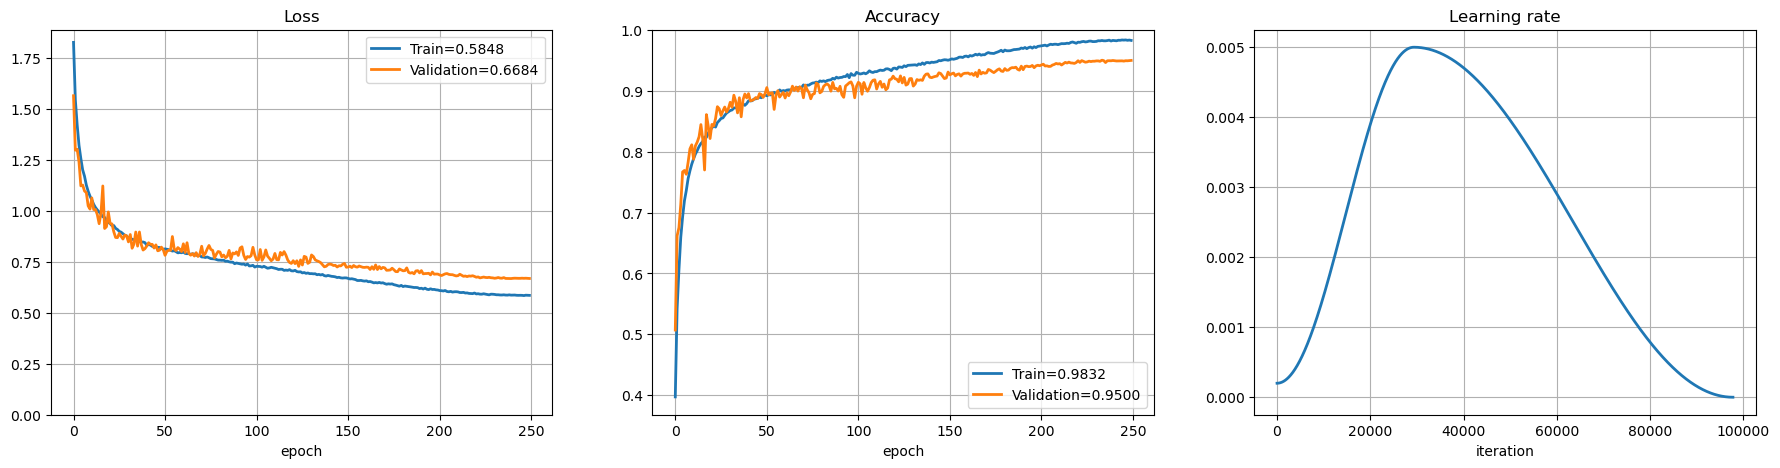

In [21]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()